In [1]:
#import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Hyperparameters

#Should we try different sequence/batch sizes? I'm surprised by how few epochs are needed for training
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 10

In [2]:
#reading and splitting of data

df = pd.read_csv("HistoricalData_1744030076399.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date")
df_filtered = df[(df["Date"].dt.year >= 2020) & (df["Date"].dt.year <= 2024)].reset_index(drop=True)

features = ["Close/Last", "Open", "High", "Low"]

#Values normalized between 0 and 1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_filtered[features])

#If particular features are mort important we can choose to weight them
#scaled_weighted = scaled * np.array([w1, w2, w3, w4, w5])

#create sequences aligns all the data
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # Predict Close/Last
    return np.array(X), np.array(y)


X, y = create_sequences(scaled, SEQ_LEN)
dates = df_filtered["Date"][SEQ_LEN:].reset_index(drop=True)


#define test and train sets then reshape data
train_idx = dates.dt.year <= 2023
test_idx = dates.dt.year == 2024

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [3]:
#definitions of models

#standard RNN, not so great with long term memory
class StockRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

#LSTM, better with long term memory
class StockLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

#GRU, less parameters
class StockGRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])


#we could choose to add in dropout options

In [4]:
#Hyperparameter values which we can loop over
from itertools import product

# Hyperparameter values to vary
hidden_sizes = [64, 128]
learning_rates = [0.001, 0.01]
num_layers_list = [1, 2]

# Create all combinations
hyperparams_grid = list(product(hidden_sizes, learning_rates, num_layers_list))

results = {}  # results[model_name][hyperparam_label] = {train_loss, pred, actual}

for name, ModelClass in [("GRU", StockGRU), ("LSTM", StockLSTM), ("RNN", StockRNN)]:
    results[name] = {}
    
    for HIDDEN_SIZE, LEARNING_RATE, NUM_LAYERS in hyperparams_grid:
        label = f"H{HIDDEN_SIZE}_LR{LEARNING_RATE}_L{NUM_LAYERS}"
        model = ModelClass(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()

        # Dataloader with fixed batch size
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)

        train_losses = []
        for epoch in range(N_EPOCHS):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = loss_fn(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            train_losses.append(total_loss / len(train_loader))

        # Predictions
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor).squeeze().numpy()
            y_actual = y_test_tensor.squeeze().numpy()
            y_pred_unscaled = scaler.inverse_transform(np.column_stack([y_pred, np.zeros((len(y_pred), 3))]))[:, 0]
            y_actual_unscaled = scaler.inverse_transform(np.column_stack([y_actual, np.zeros((len(y_actual), 3))]))[:, 0]

        results[name][label] = {
            "train_loss": train_losses,
            "pred": y_pred_unscaled,
            "actual": y_actual_unscaled
        }


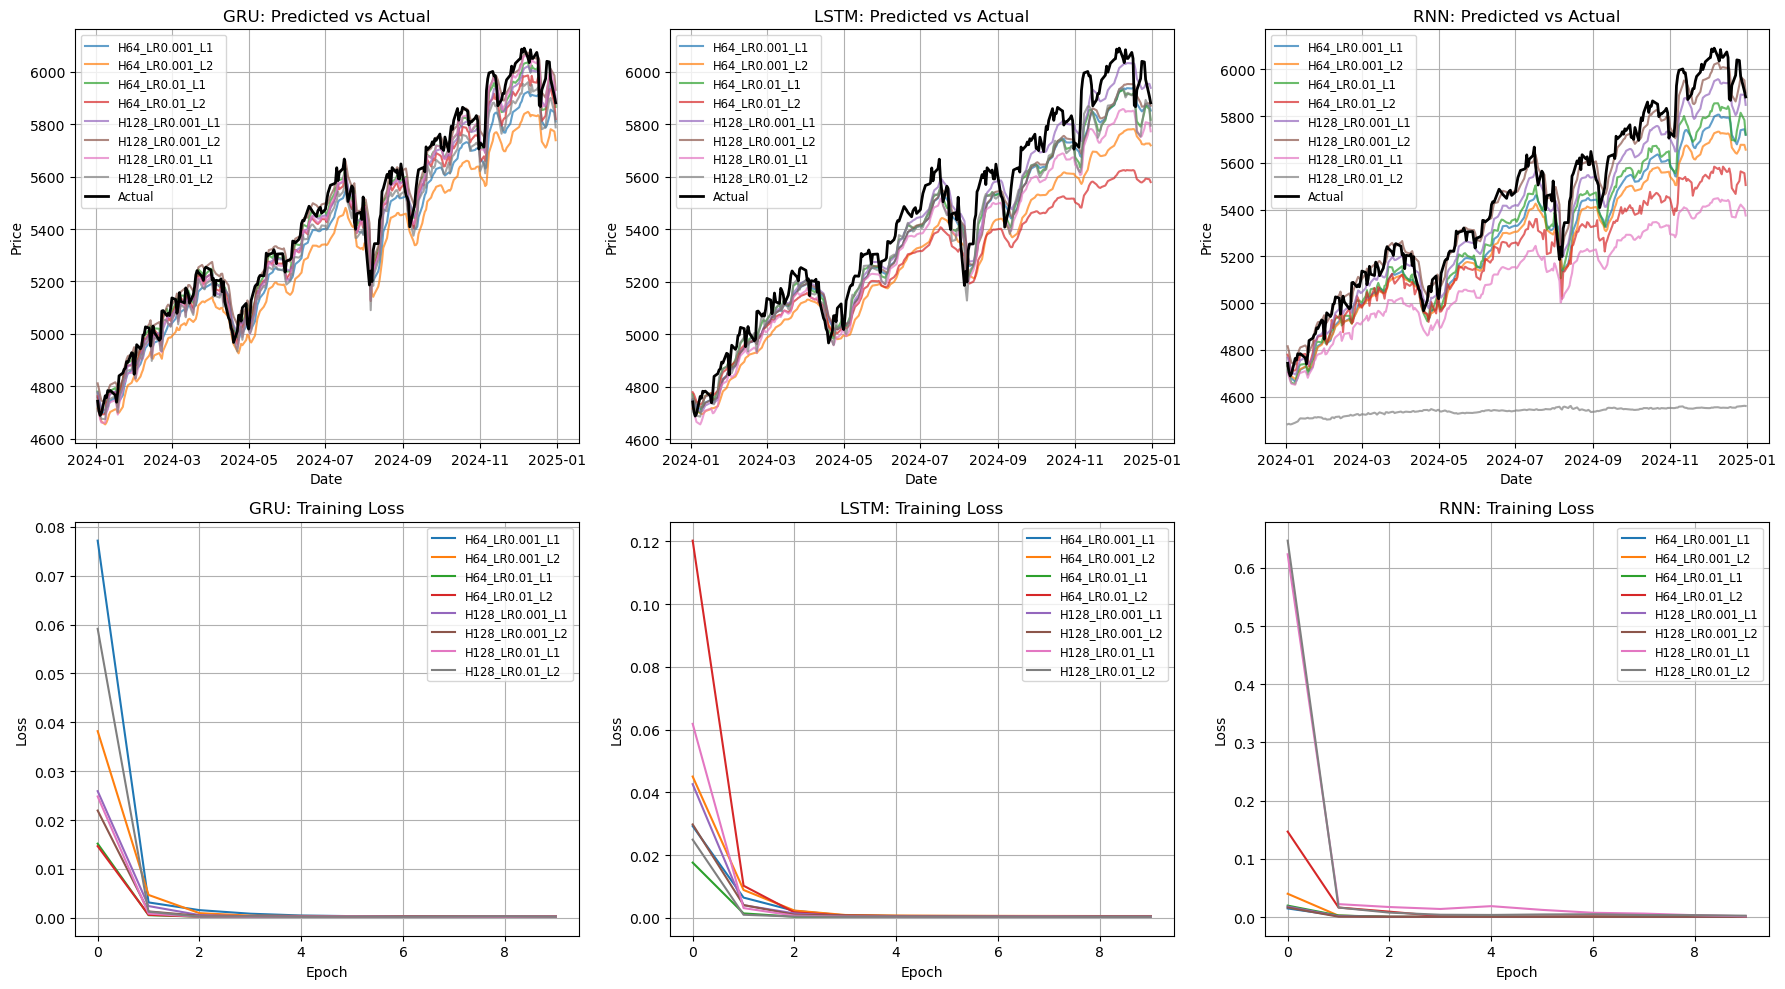

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, (name, model_results) in enumerate(results.items()):
    # Top row: Predictions
    ax1 = axs[0, idx]
    for label, res in model_results.items():
        ax1.plot(dates[test_idx].values, res["pred"], label=label, alpha=0.7)
    ax1.plot(dates[test_idx].values, res["actual"], label="Actual", color="black", linewidth=2)
    ax1.set_title(f"{name}: Predicted vs Actual")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True)
    ax1.legend(fontsize='small')

    # Bottom row: Training losses
    ax2 = axs[1, idx]
    for label, res in model_results.items():
        ax2.plot(res["train_loss"], label=label)
    ax2.set_title(f"{name}: Training Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid(True)
    ax2.legend(fontsize='small')

plt.tight_layout()
plt.show()
